# Triple-Halide Perovskites: Contour Map
KB 2022-01-02
hello

In [1]:
## Load packages
import grama as gr
import numpy as np
import plotnine as pt

## Load scikit tools
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

## Package setup
DF = gr.Intention()

In [2]:
## Barycentric converter
def tran_bary(df, a="I", b="Br", c="Cl", x="x", y="y"):
    r"""Convert to barycentric coordinates
    """
    df_tmp = df.copy()
    df_tmp[x] = 0.0 * df[a] + 1.0 * df[b] + 0.5 * df[c]
    df_tmp[y] = 0.0 * df[a] + 0.0 * df[b] + np.sqrt(1 - 0.5**2) * df[c]
    
    return df_tmp

# Pipe-enabled function
tf_bary = gr.add_pipe(tran_bary)
# Triangle boundary
df_tri_bounds = (
    gr.df_make(
        Br=[1, 0, 0, 1],
        Cl=[0, 1, 0, 0],
        I =[0, 0, 1, 0],
    )
    >> tf_bary()
)
# Labels
df_tri_labels = (
    gr.df_make(
        x=[-0.1, +1.1, +0.5],
        y=[+0.0, +0.0, +np.sqrt(1 - 0.5**2) + 0.1],
        label=["I", "Br", "Cl"]
    )
)

# Generate Example Data

In [3]:
## Made Up Triple Halide Perovskite data: 
df_thp_fake1 = (
    ## I -- Br tie
    gr.df_make(
        Br=np.linspace(0, 1, num=6),
        Cl=0,
        single_phase=True,
    )
    >> gr.tf_mutate(I=1 - DF.Br)
    
    ## Cl -- Br tie
    >> gr.tf_bind_rows(
        gr.df_make(
            Br=np.linspace(0, 0.99, num=6),
            I=0,
            single_phase=True,
        )
    >> gr.tf_mutate(Cl=1 - DF.Br)
    )    
    ## I -- Cl tie
    >> gr.tf_bind_rows(
        gr.df_make(
            Cl =np.linspace(0.1, 0.9, num=5),
            Br =0,
            single_phase=False,
        )
    >> gr.tf_mutate(I= 1 - DF.Cl)
    )    
    ## Middle of Cl -- I
    # Replicate single point to weight against densely-sampled edges
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.33, I=0.33, Br=[0.34] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.10, I=0.40, Br=[0.50] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.80, I=0.10, Br=[0.10] * 1, single_phase=True)
    )
    >> tf_bary()
)

In [4]:
## Real Triple Halide Perovskite data: 
df_thp_round1 = (
    ## I -- Br tie: MAPbBr1.5I1.5 = True
    gr.df_make(Cl=0, I=0.5, Br=[0.5] * 1, single_phase=True)
    
    ## Cl -- Br tie: MAPbBrCl = True
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0, Br=[0.5] * 1, single_phase=True)
    )  
    
    ## I -- Cl tie: MAPbI1.5Cl1.5 = False
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0.5, Br=[0] * 1, single_phase=False)
    )
    
    ## Middle of plot
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.33, I=0.33, Br=[0.34] * 1, single_phase=True)
    )

    ## Convert to barycentric coordinates
    >> tf_bary()
)

In [5]:
## Real Triple Halide Perovskite data: 
df_thp_round1corners = (
    ## I -- Br tie: MAPbBr1.5I1.5 = True
    gr.df_make(Cl=0, I=0.5, Br=[0.5] * 1, single_phase=True)
    
    ## Cl -- Br tie: MAPbBrCl = True
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0, Br=[0.5] * 1, single_phase=True)
    )  
    
    ## I -- Cl tie: MAPbI1.5Cl1.5 = False
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0.5, Br=[0] * 1, single_phase=False)
    )
    
    ## Middle of plot
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.33, I=0.33, Br=[0.34] * 1, single_phase=True)
    )
    
    ## Corners
    >> gr.tf_bind_rows(
        gr.df_make(Cl=1, I=0, Br=[0] * 1, single_phase=True)
    )  
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0, I=1, Br=[0] * 1, single_phase=True)
    )  
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0, I=0, Br=[1] * 1, single_phase=True)
    )  

    ## Convert to barycentric coordinates
    >> tf_bary()
)

# Visualize Data

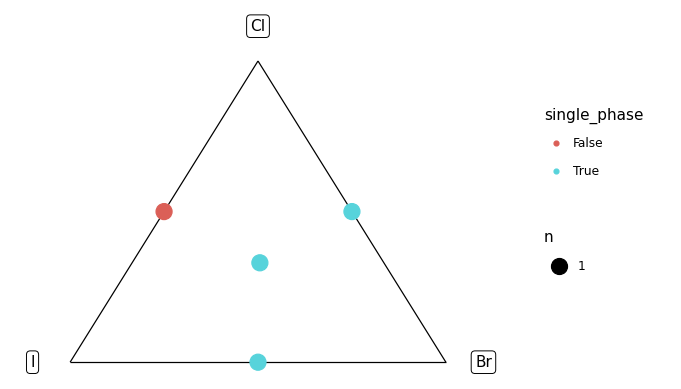

<ggplot: (168867228651)>

In [6]:
#Select data to display:
df_thp = df_thp_round1

#Show visualization
(
    df_thp
    
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
    + pt.geom_count(pt.aes(color="single_phase"))
    + pt.theme_void()
    + pt.theme(
        plot_background=pt.element_rect(fill="white")
    )
)

# Make Gaussian Process Model
Train the model

In [31]:
## Set up training data
var = ["Cl", "Br", "I"]
out = ["single_phase"]
df_train = (
    df_thp
)
X = df_train[var]
Y = np.atleast_2d(df_train[out].values)

## Fit a GP
length = 4.749 #################################.0827128880######################## Tune the lengthscale of GP
kernel = 1.0 * RBF(length)
model_gpc = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, Y)

# Package the model
md_gpc = (
#    gr.Model()
#    >> gr.cp_vec_function(
#         fun=lambda df: gr.df_make(
#             pr_single_phase=model_gpc.predict(df[var])
#             #pr_single_phase=model_gpc.predict_proba(df[var])[:, 1]
#         ),
#         var=var,
#         out=["pr_single_phase"]
#     )
    df_train
    >> gr.ft_gp(
        var=var, 
        out=out,
        kernels=kernel
    )
)

Display model in barycentric coordinates

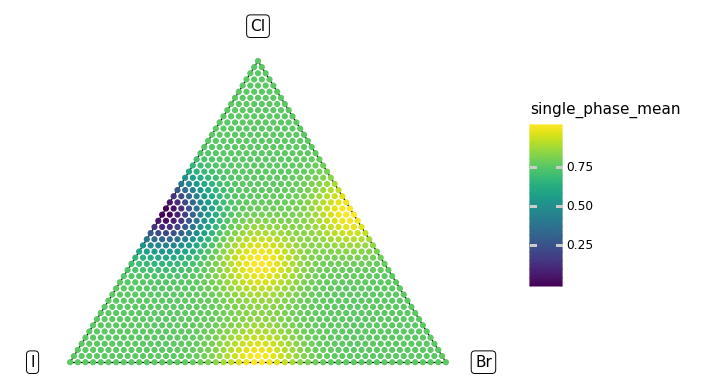

<ggplot: (168867236762)>

In [32]:
(
    gr.df_make(Br=np.linspace(0, 1, num=50))
    >> gr.tf_outer(
        df_outer=gr.df_make(Cl=np.linspace(0, 1, num=50))
    )
    >> gr.tf_filter(DF.Br + DF.Cl <= 1)
    >> gr.tf_mutate(I=1 - DF.Br - DF.Cl)
    >> tf_bary()
    >> gr.tf_md(md_gpc)
#     >> gr.tf_mutate(pr_log=gr.log(DF.pr_single_phase))
    
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
    + pt.geom_point(pt.aes(color="single_phase_mean"))
    
#     + pt.scale_color_continuous(limits=(0, 1))
    + pt.theme_void()
    + pt.theme(
        plot_background=pt.element_rect(fill="white")
    )
)

# Make Contour Map

In [ ]:
# gr.eval_contour() #see docu to modify # contours
# gr.comp_vec_function()

In [36]:
df_contour = (
gr.Model()
    >> gr.cp_vec_function( #fun = parameter that accepts a function, NOT the name of this specific function
        fun=lambda df: gr.df_make(I=1 - df.Br - df.Cl),
        var=["Br", "Cl"],
        out=["I"],
        name="compute proportion of Iodine given Cl and Br composition", #docstring of input function
    )
>> gr.cp_vec_function( #how the output is calculated from the input
    fun=lambda df: gr.df_make(
        pr_single_phase=model_gpc.predict(df[var])
    ),
    
    var=["Br", "Cl", "I"], #model only takes in Br and Cl as variables, *internally* computes I, outputs contour
    out=[out],
    )
>> gr.cp_bounds(
    Cl=(0, +1),
    Br=(0, +1),
    )
    
>> gr.ev_contour(
    var=["Br", "Cl"],
    out=[out],
    #levels = dict(pr_single_phase=[0.46, 0.50, .55, 0.6, 0.65]),
    n_side = 64, #smoothness of lines, granularity
    n_levels = 12
)
)

TypeError: unhashable type: 'list'

In [ ]:
#df_thp >> tf_bary()


  
>> gr.tf_filter(DF.Br + DF.Cl < 1)
    
>> gr.tf_mutate(I=1 - DF.Br - DF.Cl)
>> gr.tf_mutate(I_end=1 - DF.Br_end - DF.Cl_end) 
    
>> tf_bary(a="I_end", b="Br_end", c="Cl_end", x="x_end", y="y_end")
>> tf_bary(a="I", b="Br", c="Cl", x="x", y="y")

#>> gr.pt_auto()
>> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_segment(gr.aes(xend="x_end", yend="y_end", group="level", color="factor(level)",))#color="factor(level)"
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
)
    

# Testing tran_sp()

In [33]:
#gr.tran_sp()
df_sp = gr.tran_sp(, n=25, var=["Br", "Cl"], verbose="this is a message from the transform support function") #try with 3 variables?

df_sp


tran_sp finished in 17 iterations with distance criterion  nan


,Br,Cl
0,1.845541e-09,5.000000e-01
1,3.576154e-01,3.675068e-01
2,5.488428e-01,2.516091e-01
3,2.129402e-01,5.488929e-01
4,5.000801e-01,-2.115839e-03
5,3.400004e-01,3.299999e-01
6,-1.351697e-13,5.000000e-01
7,3.399980e-01,3.300046e-01
8,3.394798e-01,3.298549e-01
9,-6.796359e-03,5.046190e-01


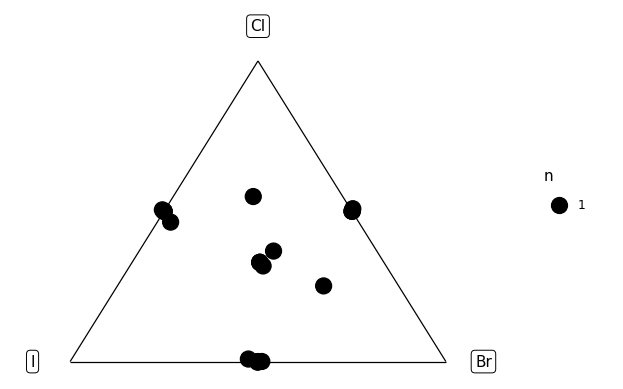

<ggplot: (168867616781)>

In [34]:
#Show visualization (currently plots points without showing stability)

(
    df_sp
    >> gr.tf_mutate(I=1 - DF.Br - DF.Cl)
    >> tf_bary(a="I", b="Br", c="Cl", x="x", y="y") #set barycentric coordinates
    >> pt.ggplot(pt.aes("x", "y"))
    # draw triangle
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    # create Cl, Br, I labels
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
    + pt.geom_count(pt.aes())#color="I"
    
    # remove grey background, make white background
    + pt.theme_void()
    
    #what does this do?
#     + pt.theme(
#         plot_background=pt.element_rect(fill="white")
#     )
)
#pt.aes() no docstring?
#gr.comp_vec_function() #adds a function to existing model